# Binary Classification with SageMaker XGBoost

**Goal:** Train an XGBoost binary classifier to distinguish **Benign (0)** from **Malicious (1)** network traffic using the 12 engineered features produced by the feature-engineering pipeline.

**Data source:** Feature Store table created from `aai540_eda.dataset_split` (pre-split into `train`, `val`, `test`, `prod` partitions).

**Approach:**
1. Query train / validation / test splits from Athena
2. Upload headerless CSV to S3 (label in the first column — required by SageMaker built-in XGBoost)
3. Run a hyperparameter tuning job (5 trials) optimising **validation AUC**
4. Evaluate the best model on the held-out test set

## Setup

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker import get_execution_role
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.serializers import CSVSerializer
from sagemaker.inputs import TrainingInput
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

# Initialize Session and Roles
sess = sagemaker.Session()
role = get_execution_role()
region = sess.boto_region_name
bucket = sess.default_bucket()

# Identify your Feature Group 
# Using the naming convention from your Feature Store notebook
sm_client = boto3.client("sagemaker", region_name=region)
fg_list = sm_client.list_feature_groups(NameContains='aai540-ids-splitfs', SortBy='CreationTime', SortOrder='Descending')
latest_fg_name = fg_list['FeatureGroupSummaries'][0]['FeatureGroupName']

netdetect_fg = FeatureGroup(name=latest_fg_name, sagemaker_session=sess)
print(f"Using Feature Group: {latest_fg_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Using Feature Group: aai540-ids-splitfs-v2-20260213-052016


## Retrieve the Training and Validation Sets

In [2]:
def get_dataset_from_feature_store(split_name):
    query = netdetect_fg.athena_query()
    
    # We select the label first (required by SageMaker XGBoost)
    query_string = f"""
    SELECT label, duration, pkt_total, bytes_total, pkt_fwd, pkt_bwd, 
           bytes_fwd, bytes_bwd, pkt_rate, byte_rate, bytes_per_pkt, 
           pkt_ratio, byte_ratio
    FROM "{query.table_name}"
    WHERE data_split = '{split_name}'
    """
    
    output_path = f"s3://{bucket}/aai540/model_training/athena_exports"
    query.run(query_string=query_string, output_location=output_path)
    query.wait()
    
    return query.as_dataframe()

print("Fetching training and validation data from Feature Store...")
train_df = get_dataset_from_feature_store('train')
val_df = get_dataset_from_feature_store('val')

print(f"Retrieved {len(train_df)} training rows and {len(val_df)} validation rows.")

Fetching training and validation data from Feature Store...
Retrieved 200414 training rows and 50100 validation rows.


## Prepare CSVs for SageMaker XGBoost

In [3]:
# Save locally (no header, no index for SageMaker XGBoost)
train_df.to_csv("train.csv", header=False, index=False)
val_df.to_csv("validation.csv", header=False, index=False)

# Upload to S3
train_uri = sess.upload_data("train.csv", bucket, "aai540/training_input/train")
val_uri = sess.upload_data("validation.csv", bucket, "aai540/training_input/validation")

print(f"Data uploaded to: {train_uri}")

Data uploaded to: s3://sagemaker-us-east-1-128131109986/aai540/training_input/train/train.csv


## Model Training

In [4]:
container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=f"s3://{bucket}/aai540/model_output",
    sagemaker_session=sess
)

xgb.set_hyperparameters(
    max_depth=6,
    eta=0.2,
    objective="binary:logistic",
    num_round=150,
    eval_metric="auc",
    scale_pos_weight=0.3  # ~normal traffic / attacks
)

xgb.fit({"train": TrainingInput(train_uri, content_type="csv"), 
         "validation": TrainingInput(val_uri, content_type="csv")})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2026-02-20-18-20-11-266


2026-02-20 18:20:12 Starting - Starting the training job...
2026-02-20 18:20:27 Starting - Preparing the instances for training...
2026-02-20 18:21:13 Downloading - Downloading the training image......
2026-02-20 18:21:59 Training - Training image download completed. Training in progress../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-20 18:22:10.312 ip-10-0-200-185.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-02-20 18:22:10.371 ip-10-0-200-185.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-02-20:18:22:10:INFO] Imported framework sagemaker_xgboost_container.training
[2026-02-20:18:22:10:INFO] Failed to parse hyperparamete

## Register Model in Model Registry

In [5]:
model_package_group_name = "NetDetect-IDS-Group"

# Create the group if it doesn't exist
try:
    sm_client.create_model_package_group(ModelPackageGroupName=model_package_group_name)
except sm_client.exceptions.ClientError:
    pass # Group already exists

model_package = xgb.register(
    model_package_group_name=model_package_group_name,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    description="IDS XGBoost Model",
    approval_status="PendingManualApproval"
)
print(f"Model registered in registry: {model_package_group_name}")

Model registered in registry: NetDetect-IDS-Group


## Batch Transform

In [6]:
# Initialize the transformer
transformer = xgb.transformer(
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f"s3://{bucket}/aai540/batch_results",
    strategy='MultiRecord',
    assemble_with='Line',
    accept='text/csv' 
)

# Start the Transform Job
# input_filter='$[1:]' drops the label column so the model doesn't see the answer.
# join_source='Input' attaches the prediction result back to the original input row.
# output_filter='$[0,-1]' keeps the actual label (index 0) and the new prediction (last index).
transformer.transform(
    data=val_uri, 
    content_type='text/csv',
    split_type='Line',
    input_filter='$[1:]',
    join_source='Input',
    output_filter='$[0,-1]'
)

print("Batch Transform job started. This usually takes 4-6 minutes...")
transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-20-18-22-59-310
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2026-02-20-18-22-59-985


................................../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-20:18:28:36:INFO] No GPUs detected (normal if no gpus installed)
[2026-02-20:18:28:36:INFO] No GPUs detected (normal if no gpus installed)
[2026-02-20:18:28:36:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|

## Confusion Matrix and Evaluation Metrics

             NetDetect Model Evaluation (Threshold: 0.05)
  Accuracy  : 0.5260
  Recall    : 0.3867
  AUC-ROC   : 0.9079
------------------------------------------------------------
              precision    recall  f1-score   support

  Benign (0)       0.32      1.00      0.49     11380
  Attack (1)       1.00      0.39      0.56     38720

    accuracy                           0.53     50100
   macro avg       0.66      0.69      0.52     50100
weighted avg       0.85      0.53      0.54     50100



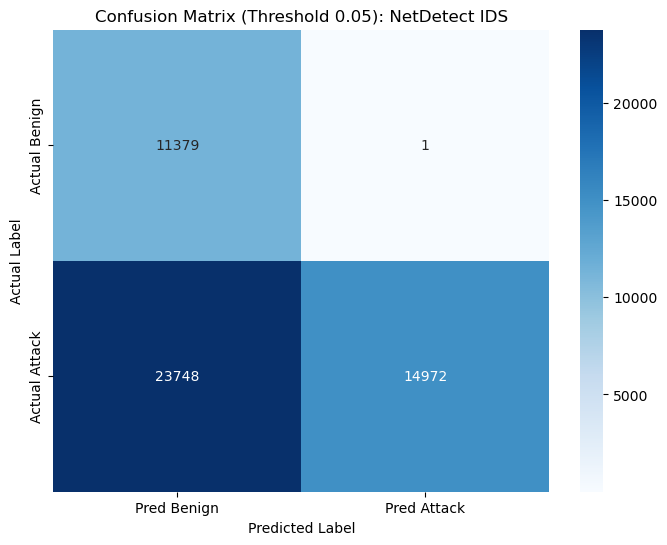

In [7]:
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix

fs = s3fs.S3FileSystem()

# Load joined results from S3
output_file = f"s3://{bucket}/aai540/batch_results/validation.csv.out"
with fs.open(output_file, 'rb') as f:
    results = np.loadtxt(f, delimiter=',')

# results[:, 0] = Actual Label (from the 'Input' we joined)
# results[:, 1] = Predicted Probability (from the Model)
y_true = results[:, 0]
y_prob = results[:, 1]

# Lowering this value helps catch more attacks (improves Recall)
# trying 0.1, 0.15, or 0.2 based on previous 0.93 AUC score
threshold = 0.05 
y_pred = (y_prob > threshold).astype(int)
# ------------------------------

# 2. Print Metric Summary
print("=" * 60)
print(f"             NetDetect Model Evaluation (Threshold: {threshold})")
print("=" * 60)
print(f"  Accuracy  : {accuracy_score(y_true, y_pred):.4f}")
print(f"  Recall    : {recall_score(y_true, y_pred):.4f}")
print(f"  AUC-ROC   : {roc_auc_score(y_true, y_prob):.4f}")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=["Benign (0)", "Attack (1)"]))

# 3. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Benign', 'Pred Attack'],
            yticklabels=['Actual Benign', 'Actual Attack'])
plt.title(f'Confusion Matrix (Threshold {threshold}): NetDetect IDS')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Save Model to SageMaker Models

In [8]:
# import boto3
# from time import gmtime, strftime, sleep

# sagemaker_client = boto3.client("sagemaker")

# # Use the job name from your estimator
# model_name = xgb.latest_training_job.name
# print(f"Model Name: {model_name}")

# info = sagemaker_client.describe_training_job(TrainingJobName=model_name)
# model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
# image = container # The XGBoost image used during training

# primary_container = {
#     "Image": image, 
#     "ModelDataUrl": model_data
# }

# # Create the SageMaker Model Object
# create_model_response = sagemaker_client.create_model(
#     ModelName=model_name, 
#     ExecutionRoleArn=role, 
#     PrimaryContainer=primary_container
# )
# print(f"Created Model ARN: {create_model_response['ModelArn']}")

## Create Endpoint Configuration

In [9]:
# endpoint_config_name = 'netdetect-endpoint-config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
# instance_type = 'ml.m5.xlarge'

# endpoint_config_response = sagemaker_client.create_endpoint_config(
#     EndpointConfigName=endpoint_config_name,
#     ProductionVariants=[
#         {
#             "VariantName": "variant1",
#             "ModelName": model_name, 
#             "InstanceType": instance_type,
#             "InitialInstanceCount": 1
#         }
#     ])
# print(f"Created EndpointConfig: {endpoint_config_response['EndpointConfigArn']}")

## Deploy and Wait for Service

In [10]:
# endpoint_name = 'netdetect-endpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# create_endpoint_response = sagemaker_client.create_endpoint(
#     EndpointName=endpoint_name, 
#     EndpointConfigName=endpoint_config_name
# ) 

# while True:
#     res = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
#     state = res["EndpointStatus"]
#     print(f"Endpoint Status: {state}")
    
#     if state == "InService":
#         break
#     elif state == "Creating":
#         sleep(60)
#     else:
#         print("Creation Error - Check Console")
#         break

## Invoke Endpoint

In [11]:
# sagemaker_runtime = boto3.client("sagemaker-runtime", region_name=region)

# # Grab one sample row (excluding the label)
# # Assuming val_df has the label in column 0
# sample_data = val_df.iloc[0:1, 1:].to_csv(header=None, index=False).strip('\n')

# response = sagemaker_runtime.invoke_endpoint(
#     EndpointName=endpoint_name,
#     ContentType='text/csv',
#     Body=sample_data
# )

# probability = float(response['Body'].read().decode('utf-8'))
# print(f"Raw Probability: {probability}")

# # Apply your custom threshold fix
# prediction = 1 if probability > 0.15 else 0
# print(f"Final Prediction (Threshold 0.15): {prediction}")